# A Hierarchical Bayesian Regression Model
## A meta-analysis of experimental studies of an education intervention 


## Milad Kharratzadeh

We consider a model with varying slopes, varying intercepts, and individual-level and group-level predictors. We motivate this model for the meta-analysis of experimental studies of an education intervention (e.g., a new coaching program). Assume that the studies were done over $N$ students in $J$ different schools. For each student, a measure of improvement, $y_n$, was achieved (e.g., the score improvment in a test compared to a pre-treatment test). For each student, we have $P$ predictors, ${\bf x}_n$, which could include the socio-economic status of the student, number of study hours, pre-treatment test score, parent's education level, etc. The first element of the predictor vector is 1 (allowing for intercept). We first pose a within-group model of how the individual-level predictors affect the measure of improvement:

$$y_n  \sim   \text{N} ({\bf x}_n^T\boldsymbol{\beta}_{g[n]}, \sigma^2), \qquad n=1, \ldots, N,$$

where $g[n]$ is the group (i.e., school) of the $n$th student. Therefore, we assume that the the coefficient vectors, $\boldsymbol{\beta}_i$, vary across schools. Next, we characterize this variation by using a multi-variate Normal distribution: 

\begin{eqnarray}
\boldsymbol{\beta}_j & \sim &\text{MVN} ({\bf u}_j^T \boldsymbol{\gamma}, \boldsymbol{\Sigma}), \qquad j=1, \ldots, J,
\end{eqnarray}

where ${\bf u}_j$ are the school-level predictors (e.g., size of classrooms or historical performance) , and $\boldsymbol{\gamma}$ is the group-level coefficient matrix. We assign a weakly informative prior, $\text{N}(0,5)$, on the elements of $\boldsymbol{\gamma}$. The covariance matrix is decomposed into a scale and a correlation matrix as follows:

\begin{eqnarray}
\boldsymbol{\Sigma} & = & \text{diag}(\boldsymbol{\tau}) \ \boldsymbol{\Omega} \  \text{diag}(\boldsymbol{\tau}), 
\end{eqnarray}

where $\boldsymbol{\tau}$ are scale coefficients and $\boldsymbol{\Omega}$ is the correlation matrix with the following priors:

\begin{eqnarray}
\boldsymbol{\tau}_i & \sim & \text{Cauchy} (0, 2.5), \quad \boldsymbol{\tau}_i>0, \qquad {weakly \ informative \ prior}, \\
\boldsymbol{\Omega} & \sim & \text{LKJcorr}(2),
\end{eqnarray}

The LKJ prior is for parameter $\nu$ is proportional to $|\text{det}(\boldsymbol{\Omega})|^{\nu-1}$.  As $\nu$ increases, the prior increasingly concentrates around the unit correlation matrix (i.e., favors less correlation among the components of $\boldsymbol{\beta}_i$ ). In Stan, the LKJ prior is applied through the Cholesky decomposition of the correlation matrix.

## Generating Simulated Data

In this notebook, we use simulated data for showcasing how Stan can be used to fit a model to the data and how we can analyse the fit of the model. In the R code below, we generate the simulated data. We assume that we have 20 schools, each with 50 students. 

In [41]:
library(mgcv)
### Generating Simulated Data:
J <- 20                 # Number of groups
Q <- 4                  # Number of group-level predictors
N <- 1000               # Number of individuals
P <- 4                  # Number of individual-level predictors
g <- rep(1:J, each=N/J) # Group memberships
sigma <- 5              # Observation error
set.seed(123456789)     # Setting the random seed for reproducability
X <- matrix(runif(N*P, min = 0, max = 2), nrow=N)   # Individual predictors
X[,1] <- 1   # Individual-level intercept
U <- matrix(runif(J*Q, min = 0, max = 5), nrow=J)   # Group predictors
U[,1] <- 1   # Group-level intercept
Beta <- matrix(NA, J, P) # Individual-level coefficients (sampled later) 
gamma <- matrix(rnorm(Q*P, mean = 0, sd = 5), nrow=Q) # Group-level coefficients
tau <- seq(from = 1, to = 4, length.out = P)   # Prior scales
Omega <- matrix(0.2,P,P) + diag(0.8,P,P)       # Prior correlation matrix
Sigma <- diag(tau) %*% Omega %*% diag(tau)     # Covariance matrix
Beta <- rmvn(J, U %*% gamma, Sigma)            # Sampling individual-level coefficients
Y <- rnorm(N,rowSums(X * Beta[g,]), sigma)     # Sampling responses

After generating the data, we fit the model using Stan. The Stan code for implementing the above model, with comments, is as follows:

In [43]:
file_path <- "HierarchicalRegression.stan";
lines <- readLines(file_path, encoding="ASCII");
for (n in 1:length(lines)) cat(lines[n],'\n');

data { 
  int<lower=1> J; // Number of groups 
  int<lower=1> Q; // Number of group-level predictors 
  int<lower=1> N; // Number of individuals 
  int<lower=1> P; // Number of individual-level predictors 
  int<lower=1, upper=J> g[N]; // Grouping 
  matrix[N, P] X; // Individual predictors 
  matrix[J, Q] U; // Group predictors 
  vector[N] Y;    // Responses 
} 
 
parameters { 
  real<lower=0> sigma;    // Observation error 
  matrix[Q, P] gamma;     // Group-level coefficients 
  matrix[P, J] Z;         // Z will be used later to build Beta 
  vector<lower=0>[P] tau; // Prior scale 
  cholesky_factor_corr[P] Omega_chol; // Cholesky decomposition of Omega 
} 
 
transformed parameters { 
  matrix[J, P] Beta;  // Individual-level coefficients 
  Beta = U * gamma + (diag_pre_multiply(tau,Omega_chol) * Z)'; 
} 
 
model { 
  to_vector(Z) ~ normal(0, 1); 
  Omega_chol ~ lkj_corr_cholesky(2); 
  to_vector(gamma) ~ normal(0, 5); 
  Y ~ normal(rows_dot_product(Beta[g] , X),sigma); 
} 


Now, we are ready to fit the model using the stan function from the library rstan. We run 2 chains of MCMC, each with 1000 iterations (the first 500 iterations of each chain are for warmup). While running, the stan function prints some information about the status of the MCMC; we omit these information in this notebook for brevity. 

In [ ]:
library("rstan")
fit <- stan("HierarchicalRegression.stan", data=c("J","Q","N","P", "g", "X","U","Y"), 
            control=list(adapt_delta=0.9, stepsize=0.005), chains=2, iter=1000, seed=1234);

In [14]:
options(width="100");
print(fit,digits=2);

Inference for Stan model: HierarchicalRegression.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff Rhat
sigma               5.14    0.00 0.11     4.93     5.07     5.14     5.22     5.36  1000 1.00
gamma[1,1]          0.23    0.05 1.60    -2.95    -0.81     0.21     1.28     3.37  1000 1.00
gamma[1,2]          1.94    0.08 1.99    -2.22     0.63     1.98     3.17     5.90   661 1.00
gamma[1,3]         -0.58    0.07 1.96    -4.39    -1.91    -0.56     0.66     3.26   855 1.00
gamma[1,4]          3.67    0.09 2.38    -1.09     2.07     3.61     5.35     8.38   719 1.00
gamma[2,1]          4.65    0.01 0.35     3.95     4.42     4.66     4.88     5.36  1000 1.00
gamma[2,2]         -2.39    0.02 0.48    -3.38    -2.69    -2.39    -2.09    -1.45   536 1.00
gamma[2,3]         -5.68    0.02 0.53    -6.76    -6.00    -5.69    -5.36    -4.60

In [5]:
mod_fit <- extract(fit)
n_sims <- length(mod_fit$lp__)
Yrep <- array(NA, c(n_sims, N))
for (s in 1:n_sims)
  Yrep[s,] <- rnorm(N,rowSums(X * mod_fit$Beta[s, g,]), mod_fit$sigma[s])  

In [24]:
library(bayesplot)

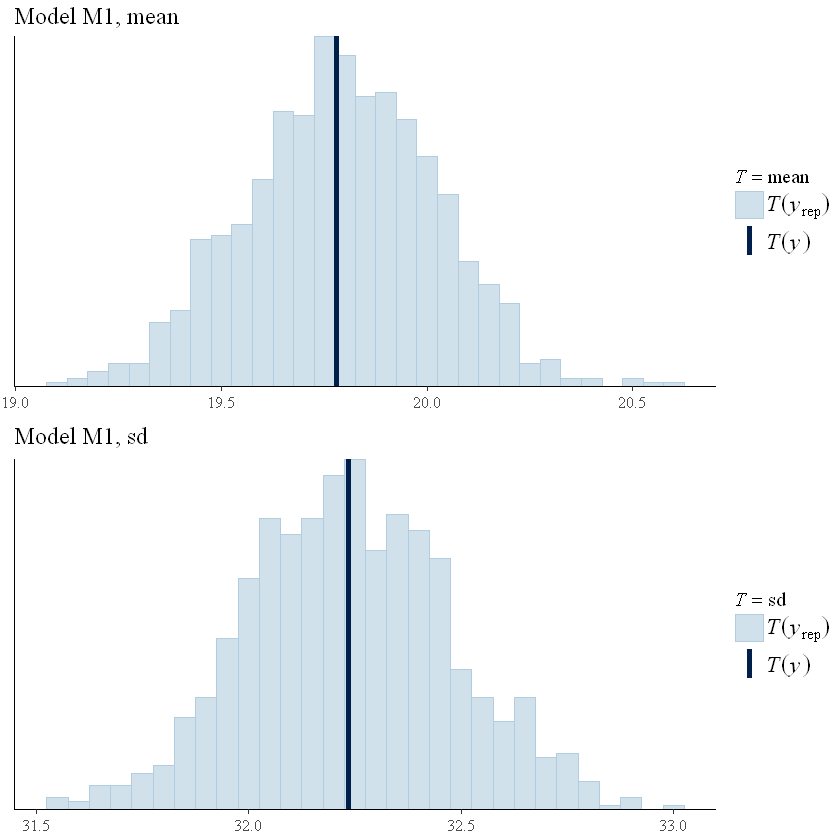

In [36]:
library("ggplot2")
library("cowplot")
library("grid")

plot1 <- ppc_stat(Y, Yrep, stat = "mean",binwidth = 0.05) + 
  ggtitle("Model M1, mean") 
plot2 <- ppc_stat(Y, Yrep, stat = "sd", binwidth = 0.05) + 
  ggtitle("Model M1, sd") 
plots <- list(plot1, plot2)
grobs <- lapply(plots, ggplotGrob)
g <-  do.call(gridExtra::rbind.gtable, grobs)
grid.newpage()
grid.draw(g)

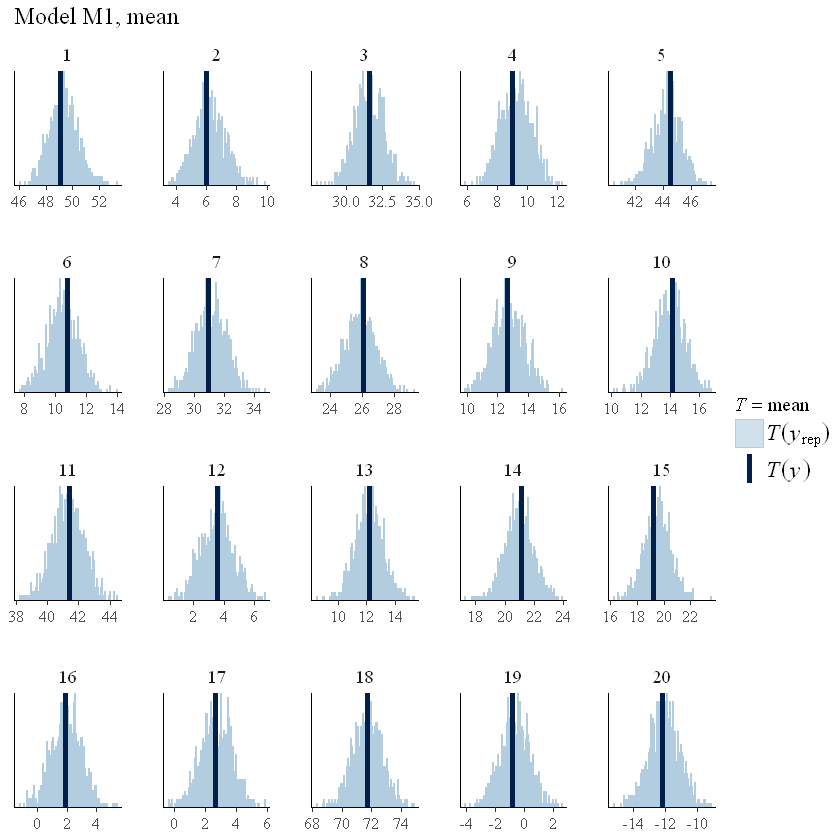

In [42]:
ppc_stat_grouped(Y, Yrep, group = g, stat = "mean", binwidth = 0.05) + 
  ggtitle("Model M1, mean") 